Data provided hold the historical records of Opportunities (a potential deal with client). Opportunity is presented by the following (main) columns (properties): OpportunityId - to identify a separate Opportunity uniquely, CreatedDate - the date of the record creation, StageName - probability and the short stage description for a successful deal closing (100% Opportunity) Amount - (a current corrected version of) sum of the (potential) deal // ??? CloseDate - forecasted deal closing date Probability - the probability of success for this opportunity at its current stage other fields - properties of the Opportunity

You have the history of interactions with clients (Opportunity is a potential deal).
You should forecast the Probability of successful deal (Opportunity) closing.
Speaking more precisely, to forecast most likely next Probability using the known previous history for this Opportunity (potential deal), namely Stage + Probability changes in previous time.
Also you could use available properties of that Opportunity

In [107]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

print(tensorflow.__version__)

2.8.0


In [108]:
df = pd.read_csv("train_data.csv")

C:\Users\Bohdan Potuzhnyi\AppData\Local\Temp\ipykernel_18960\933231161.py:1: DtypeWarning: Columns (14,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train_data.csv")


In [109]:
missing_values_count = df.isnull().sum()
missing_values_count

Unnamed: 0                             0
Id                                     0
OpportunityId                          0
CreatedById                            0
CreatedDate                            0
CreatedDateForInsert                   0
StageName                              0
Amount                                 0
Probability                            0
PrevOpportunityStageUpdate             0
ValidThroughDate                    6954
SystemModstamp                         0
IsDeleted                              0
PrevAmount                         28705
PrevCloseDate                      27916
AccountId                              0
RecordTypeId                        1704
StageSortOrder                         0
Type                                   3
LeadSource                          5536
CampaignId                             0
OwnerId                                0
Territory2Id                           0
FiscalYear                             0
FiscalQuarter   

In [110]:
data = df[df['StageName'].str.contains('100%') | df['StageName'].str.contains('0% prob')]

#print(data.loc[(data.OpportunityId == "0061300001KubxZAAR")])

data.StageName = data.StageName.apply(lambda x: '1' if '100' in x else '0')



C:\Users\Bohdan Potuzhnyi\AppData\Local\Temp\ipykernel_18960\2232586543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.StageName = data.StageName.apply(lambda x: '1' if '100' in x else '0')


<AxesSubplot:>

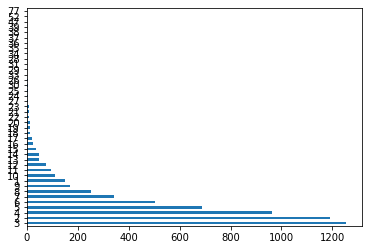

In [111]:
series = data.groupby("OpportunityId").OpportunityId.count()
series.sort_values(inplace=True)
series.head(3000)
series.value_counts().plot(kind = 'barh')
#opportunity_all = series["OpportunityId"]

In [112]:
print(series[-1])

77


In [113]:
all_opportunities = []
opp_longest = series[-1]

#used to fulfill np.array to be with max length
example_arr = []

for index, row in data.iterrows():
    #print(row)
    all_opportunities.append(row["OpportunityId"])
all_opportunities = np.unique(all_opportunities)
#print(all_opportunities)

In [114]:
### In this part for each opportunity from series DF i will create Array with all data that we
# get from functions described lower
# Firstly i will create array with all opportunities


#now create DF and convert it to array for each op from all opportunities and then push them all
# to one array

all_opportunities_array = []
final_probability_array = []
train_data_array = []
for opportunity in all_opportunities:
    opp_id = opportunity
    specific_opportinity = data.loc[(data.OpportunityId == opp_id)]
    #status = (specific_opportinity.loc[specific_opportinity.index[0], 'StageName'] == '1')
    # 1-success
    # 0-failure

    #print(status)
    specific_opportinity = specific_opportinity.sort_values(by="CreatedDateForInsert", ascending=True)
    #specific_opportinity

    #print(specific_opportinity)
    start_date = specific_opportinity.loc[specific_opportinity.index[0], "CreatedDate"]
    start_date = datetime.strptime(start_date, '%m/%d/%Y %H:%M')

    res_arr = []
    arr = []
    i = 0
    for current in specific_opportinity["CreatedDateForInsert"]:
        current_date = datetime.strptime(current, '%m/%d/%Y %H:%M')
        res_arr.append(int((current_date - start_date).days))
        if i == 0:
            arr.append(int((current_date - start_date).days))
            i+=1
        else:
            arr.append(int((current_date - start_date).days) - arr[i-1])
            i+=1

    specific_opportinity = specific_opportinity.loc[:, ["Amount", "Probability"]]
    specific_opportinity.insert(2, "Duration", res_arr)
    specific_opportinity.insert(3, "DeltaDuration", arr)
    final_probability = specific_opportinity.iloc[-1, specific_opportinity.columns.get_loc('Probability')]
    final_probability_array.append(final_probability)
    #print(final_probability)
    opp_array = np.array(specific_opportinity.iloc[-20:]).flatten()
    #print(opp_array)
    padding = np.ones(100) * 0.0
    op_ar_new = np.append(padding,opp_array)
    opp_array = op_ar_new[-80:]
    #print(opp_array)
    all_opportunities_array.append(opp_array)
    #opp_array_tensor = tensorflow.convert_to_tensor(opp_array)
    #opp_array_tensor_
    train_data_array.append([tensorflow.convert_to_tensor(opp_array), tensorflow.convert_to_tensor(final_probability)])
    # train_data_array[0].append(tensorflow.convert_to_tensor(opp_array))
    # train_data_array[1].append(tensorflow.convert_to_tensor(final_probability))
#train_data = dict(zip(train_data_array[0], train_data_array[1]))
###
# Okay array created now time for normalization i will create array with size of 20 x number of columns, 20 is choosed because 99% ended in 20 steps, and for deals that not ended at that time we will get last 20 events which will have enough information to give us understanding about deal and how it is going, it's pretty similar to how facebook acts, it's only checking for your last actions and reactions.
# after making this normalization i will be able to put this array in to tensor as series(20, columns) and than teach it
# plans changed



In [115]:
#print(all_opportunities_array[:2])
#print(final_probability_array[:2])

all_opportunities_array1 = np.asarray(all_opportunities_array)
final_probability_array1 = np.asarray(final_probability_array)
#print(all_opportunities_array1[1])
#print(final_probability_array1[1])
#final_probability_array

In [116]:
train_data_tensor = tensorflow.convert_to_tensor(train_data_array)
train_data = tensorflow.data.Dataset.from_tensor_slices(train_data_tensor)
print(train_data[0])
train_data_batch = train_data.batch(64)

InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a double tensor but is a int64 tensor [Op:Pack] name: 0

In [169]:
def base_model():
  inputs = tensorflow.keras.Input(shape=(80,))
  x = tensorflow.keras.layers.Dense(32, activation='relu')(inputs)
  x = tensorflow.keras.layers.Dense(32, activation='relu')(x)
  outputs = tensorflow.keras.layers.Dense(101, activation='softmax')(x)
  model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [170]:
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.07)
loss_object = tensorflow.keras.losses.SparseCategoricalCrossentropy()
model = base_model()
model.compile(optimizer=optimizer, loss=loss_object, metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 80)]              0         
                                                                 
 dense_27 (Dense)            (None, 32)                2592      
                                                                 
 dense_28 (Dense)            (None, 32)                1056      
                                                                 
 dense_29 (Dense)            (None, 101)               3333      
                                                                 
Total params: 6,981
Trainable params: 6,981
Non-trainable params: 0
_________________________________________________________________


In [171]:
loss_grad = []
pred_mod = []
def train_step(x, y):
  global loss_grad
  with tensorflow.GradientTape() as tape:
    pred = model(x)
    pred_mod.append(pred)
    loss = model.compiled_loss(y, pred)
    loss_grad.append(loss)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return tensorflow.linalg.global_norm(gradients)
import tqdm
epoch_num = 5
grad_norm = []
for epoch in range(epoch_num):
  for i in range(final_probability_array1.size):
    x = all_opportunities_array1[i]
    x_t = tensorflow.convert_to_tensor(x)
    x_tf = tensorflow.data.Dataset.from_tensors(x_t)
    x_tfb = x_tf.batch(80)
    x_final = 0
    for step, (x_element) in enumerate(x_tfb):
        x_final = x_element
    y_a = []
    y = final_probability_array1[i]
    y_a.append(y)
    y_at = tensorflow.convert_to_tensor(y_a)
    # print(y_at)
    # break
    grad_norm.append(train_step(x_final,y_at))


(0.2, 0.0)

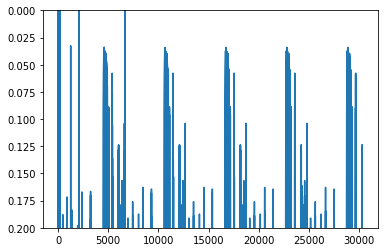

In [176]:
from matplotlib import rcParams
rcParams['ytick.labelleft'] = True
plt.plot(grad_norm)
plt.ylim(0.2, 0.0)



(0.0, 10.0)

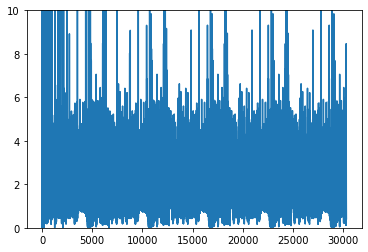

In [173]:
rcParams['ytick.labelleft'] = True
plt.plot(loss_grad)
plt.ylim(0, 10)

In [162]:
# rcParams['ytick.labelleft'] = True
# plt.plot(pred)
print(pred_mod[4200])

print(final_probability_array[4200])

tf.Tensor(
[[2.9831755e-01 3.1390006e-03 4.9641551e-07 4.2433547e-07 4.3794483e-07
  6.3997302e-03 6.8034939e-07 7.1223485e-07 7.1226879e-07 7.1231705e-07
  4.6250148e-05 5.3502271e-07 5.9143895e-07 6.4365059e-07 4.4504637e-07
  2.8741162e-02 7.1228783e-07 7.1227356e-07 6.9839632e-07 7.1234012e-07
  2.2170672e-05 7.1226401e-07 4.2284887e-07 7.1221717e-07 6.8023394e-07
  4.5104633e-05 7.1225321e-07 7.1220086e-07 4.2517888e-07 4.2274203e-07
  1.0416646e-02 4.8488465e-07 7.1155250e-07 1.9329409e-06 7.1221649e-07
  7.1156950e-07 7.0590812e-07 7.1201339e-07 1.6822381e-05 5.7038807e-07
  3.2467084e-05 6.9120637e-07 7.1225384e-07 7.1224639e-07 7.1177448e-07
  4.4310588e-07 4.2287630e-07 7.1223144e-07 7.1220154e-07 7.1224838e-07
  9.4278399e-03 4.9316882e-06 7.1077056e-07 4.2275090e-07 7.1220023e-07
  7.1223144e-07 7.1222871e-07 7.0466717e-07 7.0886495e-07 7.1225520e-07
  1.1136675e-04 7.1229999e-07 4.2343237e-07 3.0398148e-06 7.1221990e-07
  6.5057918e-07 7.1218324e-07 7.1226196e-07 4.2928255